In [2]:
gpu=2
CUDA_VISIBLE_DEVICES=gpu
!nvidia-smi

Mon Jan 24 11:21:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 48%   79C    P2   160W / 250W |   3102MiB / 11178MiB |     75%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   28C    P8     7W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
import numpy as np
import pandas as pd

# import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

# import osa
import shutil

In [4]:
import seaborn as sns
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
from glob import glob
from sklearn.metrics import roc_curve,auc, precision_score,precision_recall_curve,recall_score,precision_recall_fscore_support,confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import models
from prettytable import PrettyTable
print(torch.cuda.is_available())
import warnings
warnings.filterwarnings("ignore")
# import pandas as pd
print(torch.cuda.get_device_properties(0).total_memory)
print(torch.cuda.memory_allocated())
gpu_id = gpu

True
11721506816
0


In [13]:
train_df=pd.read_csv("/DATA/chowdari1/DATA/csv/ppr_nih_train.csv")
# test_df=pd.read_csv("/DATA/chowdari1/DATA/csv/ppr_nih_test.csv")
val_df=pd.read_csv("/DATA/chowdari1/DATA/csv/ppr_nih_val.csv")

In [14]:
train_df=train_df.sample(frac=1)

In [15]:
train_df.head()

,Unnamed: 0,Image index,target,path
4271,4271,00014534_007.png,0,/DATA/chowdari1/DATA/dataset/nih/images_007/im...
4442,4442,00015028_000.png,0,/DATA/chowdari1/DATA/dataset/nih/images_007/im...
4713,4713,00015652_000.png,0,/DATA/chowdari1/DATA/dataset/nih/images_007/im...
1376,1376,00005188_001.png,0,/DATA/chowdari1/DATA/dataset/nih/images_003/im...
6794,6794,00020997_000.png,0,/DATA/chowdari1/DATA/dataset/nih/images_010/im...


In [16]:
val_df.head()

,Unnamed: 0,Image index,target,path
0,0,00000009_000.png,1,/DATA/chowdari1/DATA/dataset/nih/images_001/im...
1,1,00000071_004.png,1,/DATA/chowdari1/DATA/dataset/nih/images_001/im...
2,2,00000071_006.png,1,/DATA/chowdari1/DATA/dataset/nih/images_001/im...
3,3,00000099_000.png,1,/DATA/chowdari1/DATA/dataset/nih/images_001/im...
4,4,00000099_001.png,1,/DATA/chowdari1/DATA/dataset/nih/images_001/im...


In [18]:
val_df.shape, train_df.shape

((1706, 4), (8574, 4))

In [19]:
train_df['target'].value_counts(), val_df['target'].value_counts(), 

(1    4313
 0    4261
 Name: target, dtype: int64,
 1    857
 0    849
 Name: target, dtype: int64)

In [20]:
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, df, img_dir, transform,start,count):
        self.ipaths = df["path"][start:count].to_numpy()
        self.target=df["target"][start:count].to_numpy()
        self.transform = transform
        self.count=count
        self.img_dir=img_dir


    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        img_path=self.img_dir+self.ipaths[idx]
        image = Image.open(img_path).convert('RGB')
        label=self.target[idx]
        image = self.transform(image)
        return image,label

In [56]:
transform=transforms.Compose([
                            #   transforms.ToPILImage(),
                              transforms.Grayscale(num_output_channels=1),
                              transforms.Resize(256),
                              transforms.CenterCrop(224),
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                              transforms.ToTensor(),
                              # transforms.Normalize((0.5,),(0.5,)
                              transforms.Normalize((0.449,),(0.226,))
])

In [31]:
normalizer=[[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
transformations = {
		'train': transforms.Compose([
			# transforms.ToPILImage(),
            transforms.Grayscale(num_output_channels=1),
			transforms.Resize(256),
			transforms.CenterCrop(224),
			transforms.RandomHorizontalFlip(),
			transforms.ColorJitter(brightness=0.25, contrast=0.25),
			transforms.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
			transforms.ToTensor(),
			transforms.Normalize(normalizer[0], normalizer[1])]),
		'val': transforms.Compose([
			transforms.Resize(256),
			transforms.CenterCrop(224),
			transforms.ToTensor(),
			transforms.Normalize(normalizer[0], normalizer[1])]),
		'test': transforms.Compose([
		transforms.Resize(256),
		transforms.CenterCrop(224),
		transforms.ToTensor(),
		transforms.Normalize(normalizer[0], normalizer[1])])	
			}


In [86]:
batch_size=64
# train_data=CustomImageDataset(train_df,'',transform,0,train_df.shape[0])
# valid_data=CustomImageDataset(val_df,'',transform,0,val_df.shape[0])
train_data=CustomImageDataset(train_df,'',transform,0,512)
valid_data=CustomImageDataset(val_df,'',transform,0,320)
# test_data=CustomImageDataset(test_df,'',transformations["test"],0,test_df.shape[0])
print(len(train_data))
# print(len(test_data))
trainloader=torch.utils.data.DataLoader(train_data, batch_size=batch_size)
# valloader=torch.utils.data.DataLoader(valid_data, batch_size=64)
testloader=torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
# testloader=torch.utils.data.DataLoader(test_data, batch_size=64)
print(trainloader)
print(len(testloader))
# dataloaders = {"train":trainloader, "val":valloader, "test": testloader}
dataloaders = {"train":trainloader,  "test": testloader}
# data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val','test']}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','test']}
data_sizes

512
5


{'train': 512, 'test': 320}

In [77]:
import torch
torch.cuda.empty_cache()
device=torch.device("cuda:2")
print("Training on GPU... Ready for HyperJump...")

Training on GPU... Ready for HyperJump...


In [74]:
torch.cuda.set_device(gpu)

In [78]:
for img,label in trainloader:
  print(img.shape)
  break
for img,label in testloader:
  print(img.shape)
  break

torch.Size([64, 1, 224, 224])
torch.Size([64, 1, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64])


torch.Size([64, 1, 224, 224])

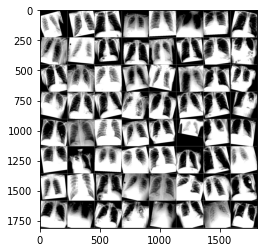

In [79]:
import torchvision
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
import matplotlib.pyplot as plt
img,lab=next(iter(trainloader))
x=torchvision.utils.make_grid(img)
imshow(x)
print(lab.shape)
img.shape

In [62]:
class Encoder(nn.Module):
        ''' This the encoder part of VAE

        '''
        def __init__(self, input_dim, hidden_dim, z_dim):
            '''
            Args:
                input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
                hidden_dim: A integer indicating the size of hidden dimension.
                z_dim: A integer indicating the latent dimension.
            '''
            super().__init__()

            self.linear = nn.Linear(input_dim, hidden_dim)
            self.mu = nn.Linear(hidden_dim, z_dim)
            self.var = nn.Linear(hidden_dim, z_dim)

        def forward(self, x):
            # x is of shape [batch_size, input_dim]

            hidden = F.relu(self.linear(x))
            # hidden is of shape [batch_size, hidden_dim]
            z_mu = self.mu(hidden)
            # z_mu is of shape [batch_size, latent_dim]
            z_var = self.var(hidden)
            # z_var is of shape [batch_size, latent_dim]

            return z_mu, z_var

In [80]:
class Decoder(nn.Module):
        ''' This the decoder part of VAE

        '''
        def __init__(self, z_dim, hidden_dim, output_dim):
            '''
            Args:
                z_dim: A integer indicating the latent size.
                hidden_dim: A integer indicating the size of hidden dimension.
                output_dim: A integer indicating the output dimension (in case of MNIST it is 28 * 28)
            '''
            super().__init__()

            self.linear = nn.Linear(z_dim, hidden_dim)
            self.out = nn.Linear(hidden_dim, output_dim)

        def forward(self, x):
            # x is of shape [batch_size, latent_dim]

            hidden = F.relu(self.linear(x))
            # hidden is of shape [batch_size, hidden_dim]

            predicted = torch.sigmoid(self.out(hidden))
            # predicted is of shape [batch_size, output_dim]

            return predicted

In [81]:
class VAE(nn.Module):
        ''' This the VAE, which takes a encoder and decoder.

        '''
        def __init__(self, enc, dec):
            super().__init__()

            self.enc = enc
            self.dec = dec

        def forward(self, x):
            # encode
            z_mu, z_var = self.enc(x)

            # sample from the distribution having latent parameters z_mu, z_var
            # reparameterize
            std = torch.exp(z_var / 2)
            eps = torch.randn_like(std)
            x_sample = eps.mul(std).add_(z_mu)

            # decode
            predicted = self.dec(x_sample)
            return predicted, z_mu, z_var

In [85]:
int_dim

3211264

In [83]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
int_dim=224*224*64
encoder = Encoder(int_dim, 224, 20)

    # decoder
decoder = Decoder(20, 224, int_dim)

    # vae
model = VAE(encoder, decoder)

    # optimizer
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [117]:
import datetime
now = datetime. datetime. now()

def train( num_epoch):  
  best_test_loss = float('inf')
  patience_counter=0
  for epochs in range(0, num_epoch):
    print('Epoch {}/{}'.format( epochs+1, num_epoch))       
    print (datetime. datetime. now())
    print('-' * 10)
    train_loss=0
    test_loss = 0
    print('Started accessing trainloader')
    phase='train'
  #   for img,lab in trainloader:
    for img, lab in tqdm.tqdm(trainloader, desc=phase, leave=False):
      img=img.view(-1,int_dim)
      img=F.softmax(img)
      #img=img.to(device)
      optimizer.zero_grad()
  # forward pass
      img_sample, z_mu, z_var = model(img)
    # print(f'before softmax : {img_sample}')
      #img_sample=F.softmax(img_sample)
    # print(f'after softmax : {img_sample}')
      recon_loss = F.binary_cross_entropy(img_sample, img, size_average=False)
  # kl divergence loss
      kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
  # total loss
      loss = recon_loss + kl_loss
      loss.backward()
      train_loss += loss.item()
      optimizer.step()
    else:
      with torch.no_grad():
        print('accessing test loader')
      #   for img,lab in testloader:
        phase='test'
        for img, lab in tqdm.tqdm(testloader, desc=phase, leave=False):
          # reshape the data
          img = img.view(-1, int_dim)
          img=F.softmax(img)
        # img=img.to(device)
          # forward pass
          img_sample, z_mu, z_var = model(img)
          #img_sample=F.softmax(img_sample)
          # reconstruction loss
          recon_loss = F.binary_cross_entropy(img_sample, img, size_average=False)
          # kl divergence loss
          kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
          # total loss
          loss = recon_loss + kl_loss
          test_loss += loss.item()

    train_loss /= len(trainloader)
    test_loss /= len(testloader)
    print(f'Epoch {epochs}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')
    if best_test_loss > test_loss:
      best_test_loss = test_loss
      patience_counter = 1
    else:
      patience_counter += 1
    if patience_counter > 3:
      print('best_test_loss: ',best_test_loss)
      break
  print('best_test_loss: ',best_test_loss)

      


In [123]:
torch.__version__

'1.6.0'

In [119]:
print(torch.cuda.is_available())

True


In [118]:
train(2)

Epoch 1/2
2022-01-24 13:07:43.055062
----------
Started accessing trainloader


accessing test loader


Epoch 0, Train Loss: 3250.26, Test Loss: 363.27
Epoch 2/2
2022-01-24 13:08:47.530962
----------
Started accessing trainloader


accessing test loader


Epoch 1, Train Loss: 1648.80, Test Loss: 397.01
best_test_loss:  363.2715545654297


torch.Size([1, 20])
torch.Size([224, 224])


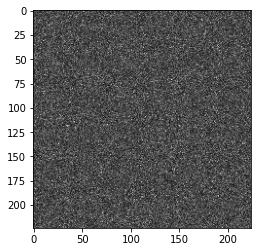

In [113]:
z = torch.randn(1, 20)
# run only the decoder
reconstructed_img = model.dec(z)
img = reconstructed_img.view(64,224,224).data
img=img[0]
print(z.shape)
print(img.shape)
plt.imshow(img,cmap='gray')
from torchvision.utils import save_image
save_image(img, './images/3ep.jpeg')
# img=transforms.ToPILImage(img),
# img=img.save('/images/3ep.png')

In [106]:
img

tensor([[0.0428, 0.0624, 0.0468,  ..., 0.0797, 0.0460, 0.0441],
        [0.0495, 0.0774, 0.0436,  ..., 0.0579, 0.0439, 0.0549],
        [0.0635, 0.0415, 0.0606,  ..., 0.0554, 0.0509, 0.0446],
        ...,
        [0.0561, 0.0525, 0.0413,  ..., 0.0688, 0.0564, 0.0428],
        [0.0666, 0.0566, 0.0383,  ..., 0.0402, 0.0362, 0.0316],
        [0.0331, 0.0643, 0.0525,  ..., 0.0413, 0.0588, 0.0459]])

In [111]:
from torchvision.utils import save_image
save_image(img, './images/img1.png')